In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN , Input,Flatten, LSTM
from tensorflow.keras import backend as K
from keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

2025-05-22 13:45:40.618327: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 13:45:40.619959: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 13:45:40.623803: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 13:45:40.634619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747946740.651782 3504679 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747946740.65

In [2]:
opened = []

csv_path = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/'
masterlist = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_FINAL_REVISED.csv'

# Load the master list of stations
stations_df = pd.read_csv(masterlist)

# Extract station numbers, areas, and latitudes
station_num = stations_df['grdc_no']
station_area = stations_df['area']
station_lat = stations_df['lat']
station_avgslope = stations_df['avg_slope']
station_maxslope = stations_df['max_slope']
station_aridity = stations_df['avg_aridity']

# Map station numbers to areas and latitudes
station_area_map = dict(zip(station_num, station_area))
station_lat_map = dict(zip(station_num, station_lat))
station_avgslope_map = dict(zip(station_num, station_avgslope))
station_maxslope_map = dict(zip(station_num, station_maxslope))
station_aridity_map = dict(zip(station_num, station_aridity))

# Generate the list of file paths
arrayFile = [os.path.join(csv_path, f"{station_no}.csv") for station_no in station_num]
# print(arrayFile)
# Initialize a list to store opened DataFrames
for file in arrayFile:
    station_no = os.path.basename(file).split('.')[0]
    # print(station_no)# Extract station number from the filename
    if os.path.exists(file):  # Check if file exists
        df = pd.read_csv(file, index_col=None, header=0)
        station_no_int = int(station_no)  # Convert station number to integer for lookup
        df['GRDC_No'] = station_no_int  # Add the station number as a new column
        df['Area'] = station_area_map.get(station_no_int, None)  # Add the Area column
        df['Latitude'] = station_lat_map.get(station_no_int, None)  # Add the latitude column
        df['Avg Slope'] = station_avgslope_map.get(station_no_int, None)
        df['Max Slope'] = station_maxslope_map.get(station_no_int, None)
        df['Aridity'] = station_aridity_map.get(station_no_int, None)
        opened.append(df)

# Combine all DataFrames into one
total_df = pd.concat(opened, axis=0, ignore_index=True)

# Print or save the resulting DataFrame
print(total_df)

       Unnamed: 0     Date       Q       SWE    SWE_scaled  GRDC_No      Area  \
0               0  2018-08  24.526  2.087791  1.809042e+06  1159100  866486.0   
1               1  2018-09  31.372  1.835435  1.590379e+06  1159100  866486.0   
2               2  2018-10  19.572  1.976332  1.712464e+06  1159100  866486.0   
3               3  2018-11   7.349  1.633273  1.415208e+06  1159100  866486.0   
4               4  2018-12  13.824  1.782850  1.544815e+06  1159100  866486.0   
...           ...      ...     ...       ...           ...      ...       ...   
23053          57  2023-05   3.046  3.400061  5.610100e+04  6594090   16500.0   
23054          58  2023-06   2.489  3.195970  5.273351e+04  6594090   16500.0   
23055          59  2023-07   2.021  3.656259  6.032828e+04  6594090   16500.0   
23056          60  2023-08   2.067  3.578097  5.903860e+04  6594090   16500.0   
23057          61  2023-09   2.483  3.630205  5.989839e+04  6594090   16500.0   

       Latitude  Avg Slope 

In [3]:
landcover = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/ALL_STATIONS_LANDCOVER.csv'
landcover_df = pd.read_csv(landcover)

# Ensure number and GRDC_No are of the same type
total_df['GRDC_No'] = total_df['GRDC_No'].astype(int)
landcover_df['number'] = landcover_df['number'].astype(int)

# Initialize empty lists for new columns
new_columns = {col: [] for col in landcover_df.columns if col != 'number'}

# Loop through total_df and match with landcover_df
for grdc_no in total_df['GRDC_No']:
    match = landcover_df[landcover_df['number'] == grdc_no]
    
    if not match.empty:
        for col in new_columns:
            new_columns[col].append(match[col].values[0])  # Append matched value
    else:
        for col in new_columns:
            new_columns[col].append(None)  # Append NaN if no match found

# Convert lists to a DataFrame and concatenate with total_df
new_data = pd.DataFrame(new_columns)
total_df = pd.concat([total_df, new_data], axis=1)

print(total_df.head())

   Unnamed: 0     Date       Q       SWE   SWE_scaled  GRDC_No      Area  \
0           0  2018-08  24.526  2.087791  1809042.021  1159100  866486.0   
1           1  2018-09  31.372  1.835435  1590378.590  1159100  866486.0   
2           2  2018-10  19.572  1.976332  1712463.856  1159100  866486.0   
3           3  2018-11   7.349  1.633273  1415208.035  1159100  866486.0   
4           4  2018-12  13.824  1.782850  1544814.625  1159100  866486.0   

   Latitude  Avg Slope  Max Slope  ...        11        12        13  \
0 -28.75799   0.745665  22.007082  ...  0.725055  0.678026  0.634266   
1 -28.75799   0.745665  22.007082  ...  0.725055  0.678026  0.634266   
2 -28.75799   0.745665  22.007082  ...  0.725055  0.678026  0.634266   
3 -28.75799   0.745665  22.007082  ...  0.725055  0.678026  0.634266   
4 -28.75799   0.745665  22.007082  ...  0.725055  0.678026  0.634266   

         14        15        16       17        18   19  20  
0  0.625967  0.632506  0.746809  0.80591  0.0860

In [4]:
soiltype = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/ALL_STATIONS_SOILTYPE.csv'
soiltype_df = pd.read_csv(soiltype)
# print(soiltype_df.head())
# Ensure number and GRDC_No are of the same type
total_df['GRDC_No'] = total_df['GRDC_No'].astype(int)
soiltype_df['number'] = soiltype_df['number'].astype(int)

# Initialize empty lists for new columns
new_columns = {col: [] for col in soiltype_df.columns if col != 'number'}

# Loop through total_df and match with landcover_df
for grdc_no in total_df['GRDC_No']:
    match = soiltype_df[soiltype_df['number'] == grdc_no]
    
    if not match.empty:
        for col in new_columns:
            new_columns[col].append(match[col].values[0])  # Append matched value
    else:
        for col in new_columns:
            new_columns[col].append(None)  # Append NaN if no match found

# Convert lists to a DataFrame and concatenate with total_df
new_data = pd.DataFrame(new_columns)
total_df = pd.concat([total_df, new_data], axis=1)

print(total_df.head())

   Unnamed: 0     Date       Q       SWE   SWE_scaled  GRDC_No      Area  \
0           0  2018-08  24.526  2.087791  1809042.021  1159100  866486.0   
1           1  2018-09  31.372  1.835435  1590378.590  1159100  866486.0   
2           2  2018-10  19.572  1.976332  1712463.856  1159100  866486.0   
3           3  2018-11   7.349  1.633273  1415208.035  1159100  866486.0   
4           4  2018-12  13.824  1.782850  1544814.625  1159100  866486.0   

   Latitude  Avg Slope  Max Slope  ...         7         8         9  \
0 -28.75799   0.745665  22.007082  ...  1.132788  1.497797  5.198238   
1 -28.75799   0.745665  22.007082  ...  1.132788  1.497797  5.198238   
2 -28.75799   0.745665  22.007082  ...  1.132788  1.497797  5.198238   
3 -28.75799   0.745665  22.007082  ...  1.132788  1.497797  5.198238   
4 -28.75799   0.745665  22.007082  ...  1.132788  1.497797  5.198238   

         10       11       12   13   14   15   16  
0  0.453115  0.98175  2.17747  0.0  0.0  0.0  0.0  
1  0.4

In [5]:
q = total_df['Q']
swe = total_df['SWE']
scaled = total_df['SWE_scaled']
area = total_df['Area']
station = total_df['GRDC_No']
lat = total_df['Latitude']
avg_slope = total_df['Avg Slope']
max_slope = total_df['Max Slope']
avg_aridity = total_df['Aridity']

In [6]:
lc_types = total_df.iloc[:, 11:-16]
soil_types = total_df.iloc[:, -16:]

# lc_types = lc_types/100
# soil_types = soil_types/100

print(lc_types)
print(soil_types)

              1          2          3         4         5         6         7  \
0      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
1      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
2      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
3      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
4      6.136561  60.524866  17.803458  3.554480  1.860924  1.402201  1.166174   
...         ...        ...        ...       ...       ...       ...       ...   
23053  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   
23054  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   
23055  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   
23056  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   
23057  5.348157  14.675249  16.582797  9.654769  5.874781  4.628438  4.253950   

              8         9  

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

# lc_in = lc_types.idxmax(axis=1)
# soil_in = soil_types.idxmax(axis=1)
# print(lc_class)

# lat_in = (lat*np.pi)/180
# Convert q and swe to NumPy arrays
scaled_in = scaled.to_numpy()  # Assume scaled is a pandas Series
area_in = area.to_numpy()      # Assume area is a pandas Series
lat_in = lat.to_numpy()
avg_slope_in = avg_slope.to_numpy()
# avg_slope_in = (avg_slope_in*np.pi)/180
max_slope_in = max_slope.to_numpy()
# max_slope_in = (max_slope_in*np.pi)/180
avg_aridity_in = avg_aridity.to_numpy()
# avg_aridity_in = avg_aridity_in*0.0001
y = q.to_numpy()            # Target variable

# lc_in = lc_types.to_numpy()
# soil_in = soil_types.to_numpy()

# Convert q and swe to NumPy arrays
# scaled_in = scaled_in/max(scaled_in)  # Assume scaled is a pandas Series
# area_in = area_in/max(area_in)      # Assume area is a pandas Series
# lat_in = lat_in/180
# avg_slope_in = avg_slope_in/180
# max_slope_in = max_slope_in/180
# avg_aridity_in = avg_aridity_in/max(avg_aridity_in)
# y = y/max(y)            # Target variable
# lc_in = lc_types/max(lc_types)
# soil_in = soil_types/max(soil_types)

# Step 1: Replace zeros with a small value
scaled_in[scaled_in == 0] = 1e-9
area_in[area_in == 0] = 1e-9
lat_in[lat_in == 0] = 1e-9
avg_slope_in[avg_slope_in == 0] = 1e-9
max_slope_in[max_slope_in == 0] = 1e-9
avg_aridity_in[avg_aridity_in == 0] = 1e-9
y[y == 0] = 1e-9

# Step 2: Combine features into a 2D array
X = np.column_stack((scaled_in, area_in, lat_in, avg_slope_in, max_slope_in, lc_types, soil_types))  # Shape will be (num_samples, 2)
# Step 3: Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
print(X_scaled[0])
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

[0.04218477 0.18426304 0.10942487 0.05021058 0.49462185 0.07071869
 0.60937122 0.18412169 0.05596715 0.01898438 0.02863306 0.04942357
 0.0614902  0.05019695 0.01338399 0.03921611 0.03248417 0.05217229
 0.0542117  0.04254099 0.02950674 0.03364036 0.01020581 0.
 0.         0.         0.09342194 0.47702958 0.0254248  0.13466151
 0.24241661 0.0119402  0.02133227 0.05308839 0.00453115 0.01931485
 0.02201936 0.         0.         0.         0.        ]


In [8]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# import pandas as pd

# # Standardize the data
# # scaler = StandardScaler()
# # X_df = total_df.drop(['Date','GRDC_No'],axis=1)
# # scaled_X = scaler.fit_transform(X_df)

# pca = PCA(n_components=3)
# pca.fit(X_scaled)
# pca_X = pca.transform(X_scaled)

# # Create a new DataFrame with the principal components
# pca_df = pd.DataFrame(data=pca_X, columns=['pc1','pc2','pc3'])

# # Display the explained variance ratio
# print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# # To see the importance of each feature for the principal components
# # The components_ attribute holds the loadings (how much each feature contributes to each principal component)
# loadings = pd.DataFrame(pca.components_, columns=['SWE','Area','Latitude','Avg Slope','Max Slope','Land Cover','Soil Texture'], index=[f'PC{i+1}' for i in range(pca.n_components_)])
# # print(loadings)

# # Optionally, you can sort the loadings to identify the most important features
# # Example: Sort by PC1 loadings
# print("Top features for PC1:")
# print(loadings.loc['PC1'].abs().sort_values(ascending=False).head())

In [33]:
# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define the model
model = Sequential([
    Dense(512, input_dim=41, activation='leaky_relu'),
    Dense(256, activation='leaky_relu'),
    Dropout(0.2),
    Dense(128, activation='leaky_relu'),
    Dropout(0.2),
    Dense(64, activation='leaky_relu'),
    Dropout(0.2),
    Dense(32, activation='leaky_relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
from tensorflow.keras.optimizers import RMSprop, Nadam
from tensorflow.keras.losses import Huber
model.compile(optimizer=Nadam(learning_rate=1e-3), loss=Huber(delta=0.1), metrics=['mae','r2_score'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,  # High epochs with early stopping
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/150


/global/home/users/arvalcarcel/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.9732e-04 - mae: 0.0088 - r2_score: -0.3093 - val_loss: 4.7777e-05 - val_mae: 0.0022 - val_r2_score: 0.8371 - learning_rate: 0.0010
Epoch 2/150
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3358e-05 - mae: 0.0035 - r2_score: 0.7628 - val_loss: 6.1586e-05 - val_mae: 0.0025 - val_r2_score: 0.7647 - learning_rate: 0.0010
Epoch 3/150
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4961e-05 - mae: 0.0031 - r2_score: 0.8132 - val_loss: 7.3580e-05 - val_mae: 0.0025 - val_r2_score: 0.7052 - learning_rate: 0.0010
Epoch 4/150
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8161e-05 - mae: 0.0030 - r2_score: 0.8078 - val_loss: 7.5834e-05 - val_mae: 0.0024 - val_r2_score: 0.6852 - learning_rate: 0.0010
Epoch 5/150
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.0293e-05 - mae: 0.0031 - r2_score: 0.8057 - val_loss: 4.2203e-05 - val_mae: 0.0021 - val_r2_score: 0.8617 - learning_rate: 0.0010
Epoch 6/150
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

In [35]:
# Step 7: Evaluate
test_loss = model.evaluate(X_test, y_test)
print(f"Test MAPE: {test_loss}")

# Step 8: Predict
predictions = model.predict(X_test)
y_pred = scaler_y.inverse_transform(predictions)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0708e-05 - mae: 0.0020 - r2_score: 0.8658
Test MAPE: [3.44707841577474e-05, 0.0017524223076179624, 0.8954308032989502]
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [36]:
y_pred = model.predict(X_test)

def nse(predictions, targets):
    return 1 - (np.sum((targets - predictions) ** 2) / np.sum((targets - np.mean(targets)) ** 2))

nse(y_pred, y_test)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step


0.8954308418760324

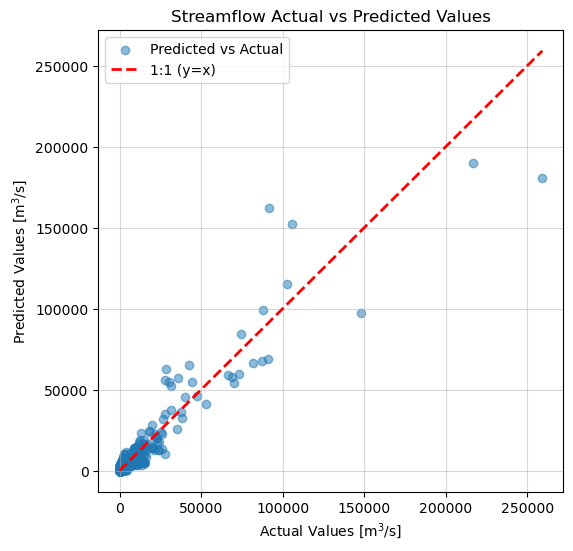

In [13]:
# Step 1: Predict values
# y_pred = model.predict(X_test)
# y_pred = np.expm1(y_pred)

# Step 2: Create the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m${^3}$/s]")
plt.ylabel("Predicted Values [m${^3}$/s]")
plt.legend()
# plt.xlim(0,25000)
# plt.ylim(0,25000)
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

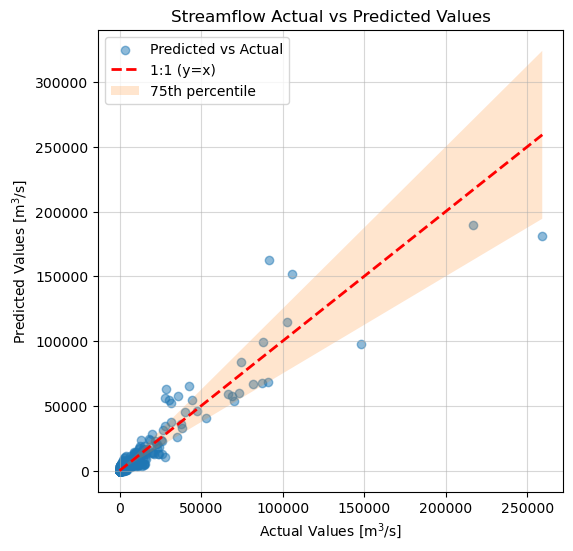

In [14]:
error = 0.25*np.arange(y.min(), y.max(),100)
y_err = np.arange(y.min(), y.max(),100)

# Step 2: Create the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)
plt.fill_between(y_err, y_err-error, y_err+error,alpha=0.2,label='75th percentile')

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m${^3}$/s]")
plt.ylabel("Predicted Values [m${^3}$/s]")
plt.legend(loc='upper left')
# plt.xlim(0,25000)
# plt.ylim(0,25000)
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

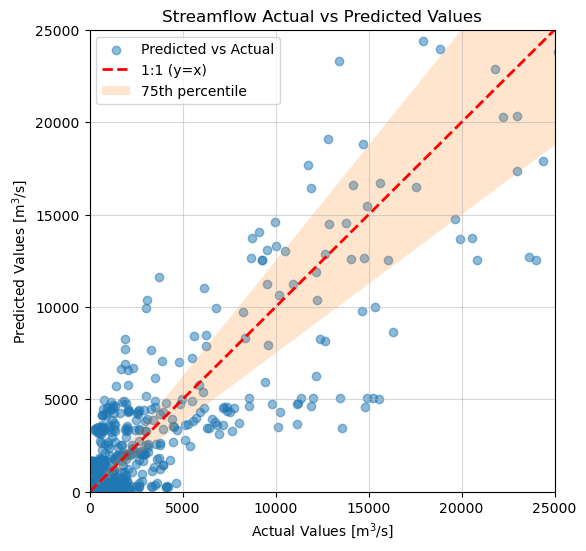

In [15]:
# zoomed in plot
# y_pred = model.predict(X_test)
# # y_pred = np.expm1(y_pred)

# Step 2: Create the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)
plt.fill_between(y_err, y_err-error, y_err+error,alpha=0.2,label='75th percentile')

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m${^3}$/s]")
plt.ylabel("Predicted Values [m${^3}$/s]")
plt.legend()
plt.xlim(0,25000)
plt.ylim(0,25000)
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

/tmp/ipykernel_3504679/3178928992.py:3: RuntimeWarning: divide by zero encountered in log
  xlog = np.log(y_test*max(y))
/tmp/ipykernel_3504679/3178928992.py:4: RuntimeWarning: invalid value encountered in log
  ylog = np.log(y_pred*max(y))


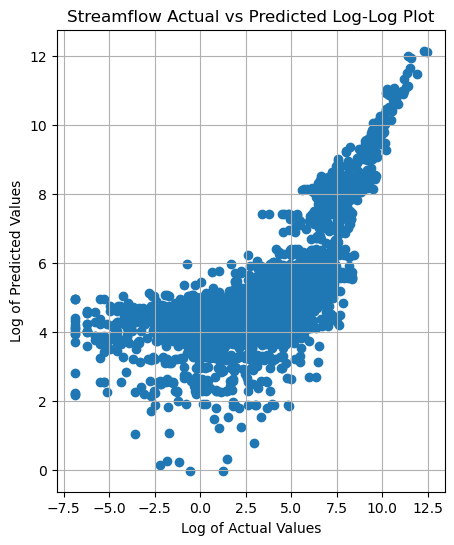

In [16]:
# Create the log-log plot

xlog = np.log(y_test*max(y))
ylog = np.log(y_pred*max(y))

plt.figure(figsize=(5,6))
plt.scatter(xlog, ylog)
# Add labels and title
plt.xlabel('Log of Actual Values')
plt.ylabel('Log of Predicted Values')
plt.title('Streamflow Actual vs Predicted Log-Log Plot')

# Customize gridlines (optional)
plt.grid(True, which="both", ls="-")

# Show the plot
plt.show()

In [17]:
# Extract loss and validation loss from the training history
test_values = y_test*max(y)
pred_values = y_pred*max(y)

test_values = np.ravel(test_values)
pred_values = np.ravel(pred_values)

# Create a new DataFrame
pred_df = pd.DataFrame({
    'Test Values': test_values,
    'Predicted Values': pred_values
})

file_path =  '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/test_vs_pred_values.csv'

# Export to a CSV file
# pred_df.to_csv(file_path, index=False)

from sklearn.metrics import r2_score

# Assuming test_values and pred_values are 1D arrays or lists
r_squared = r2_score(test_values, pred_values)
print(f"R-squared value: {r_squared}")


R-squared value: 0.893711437986254


Mean Squared Error (MSE): 8.912524392347204e-05


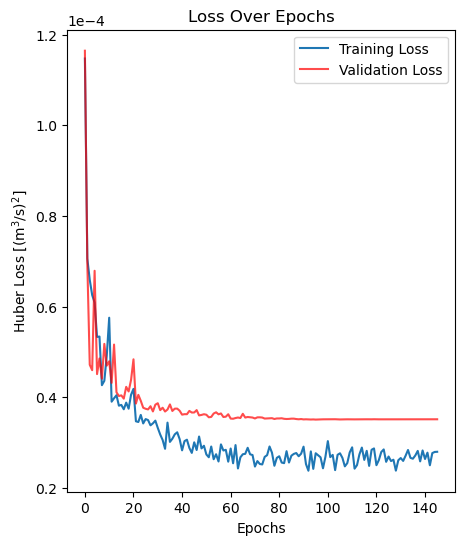

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Extract loss and validation loss from the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a new DataFrame
loss_df = pd.DataFrame({
    'Epoch': range(1, len(training_loss) + 1),  # Adding epoch numbers
    'Training Loss': training_loss,
    'Validation Loss': validation_loss
})

file_path =  '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/training_validation_losses.csv'

# Export to a CSV file
loss_df.to_csv(file_path, index=False)

# print((max(y_train) - min(y_train))**2)
plt.figure(figsize=(5,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss',color='r',alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Huber Loss [(m${^3}$/s)${^2}$]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title('Loss Over Epochs')
# plt.ylim(0.00001, 0.0002)
plt.legend()
plt.show()


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


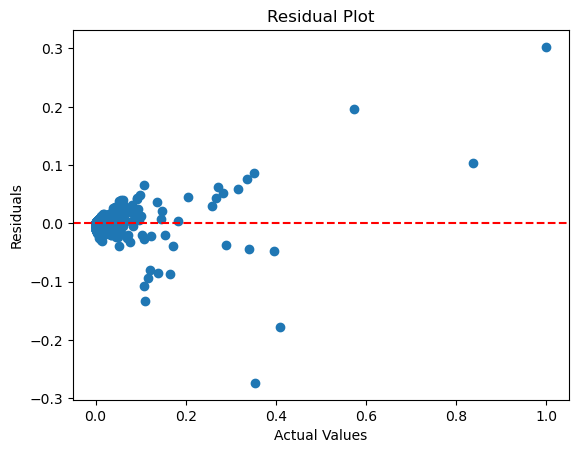

In [19]:
import matplotlib.pyplot as plt

residuals = y_test - model.predict(X_test)
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


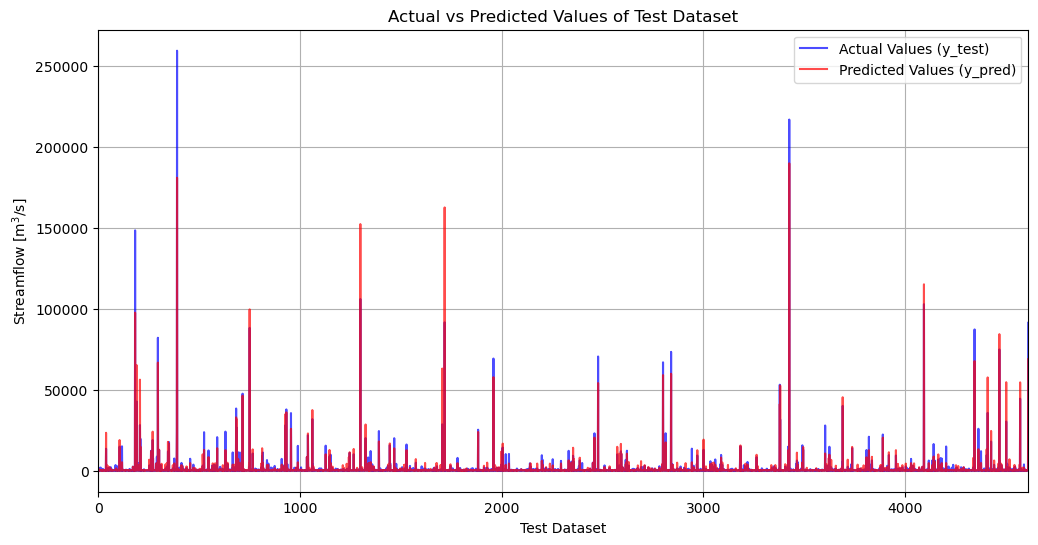

In [20]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test*max(y), label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot(np.arange(len(y_pred)), y_pred*max(y), label="Predicted Values (y_pred)", color="red", alpha=0.7)
plt.title("Actual vs Predicted Values of Test Dataset")
plt.xlabel("Test Dataset")
plt.ylabel("Streamflow [m${^3}$/s]")
plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

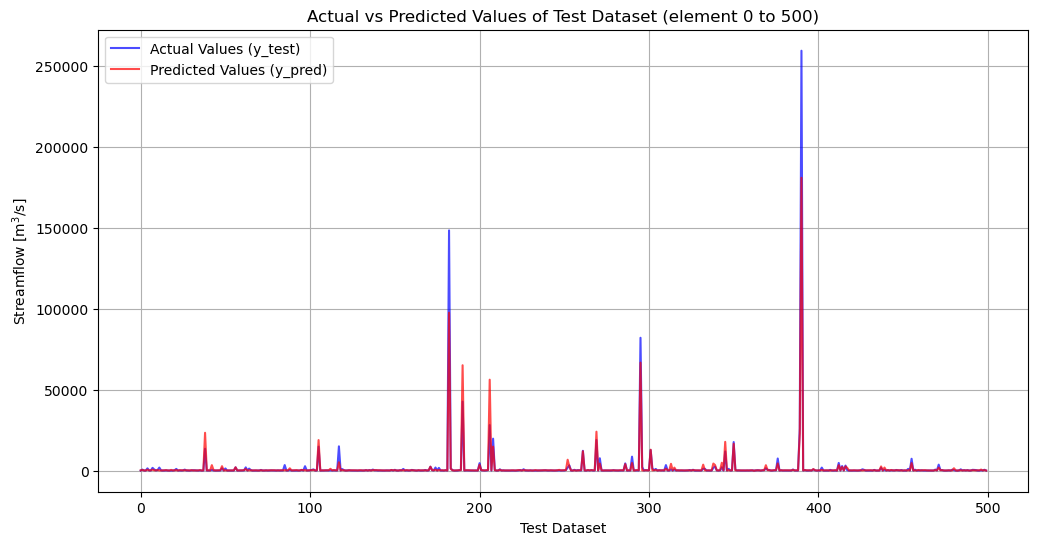

In [21]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot((np.arange(len(y_test)))[0:500], (y_test*max(y))[0:500], label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot((np.arange(len(y_pred)))[0:500], (y_pred*max(y))[0:500], label="Predicted Values (y_pred)", color="red", alpha=0.7)

# Add titles and labels
plt.title("Actual vs Predicted Values of Test Dataset (element 0 to 500)")
plt.xlabel("Test Dataset")
plt.ylabel("Streamflow [m${^3}$/s]")
# plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

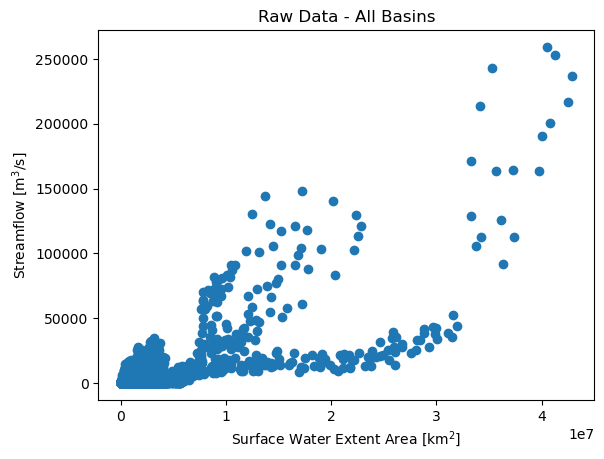

In [22]:
plt.scatter(scaled,q)
plt.title('Raw Data - All Basins')
plt.xlabel('Surface Water Extent Area [km${^2}$]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

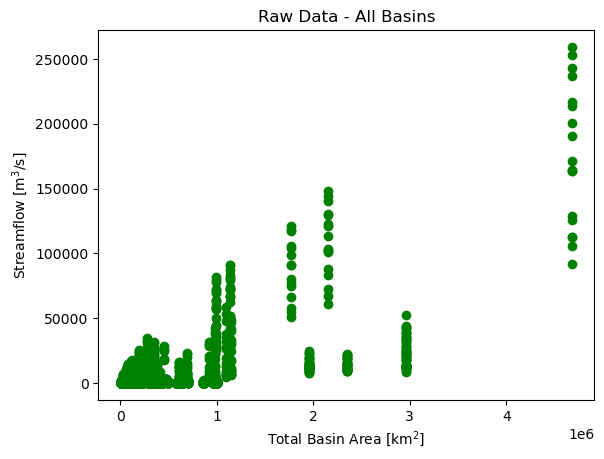

In [23]:
plt.scatter(area,q,color='g')
plt.title('Raw Data - All Basins')
plt.xlabel('Total Basin Area [km${^2}$]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

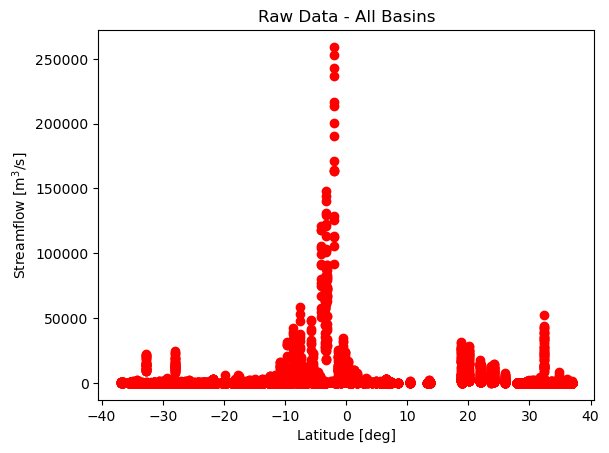

In [24]:
plt.scatter(lat,q,color='r')
plt.title('Raw Data - All Basins')
plt.xlabel('Latitude [deg]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

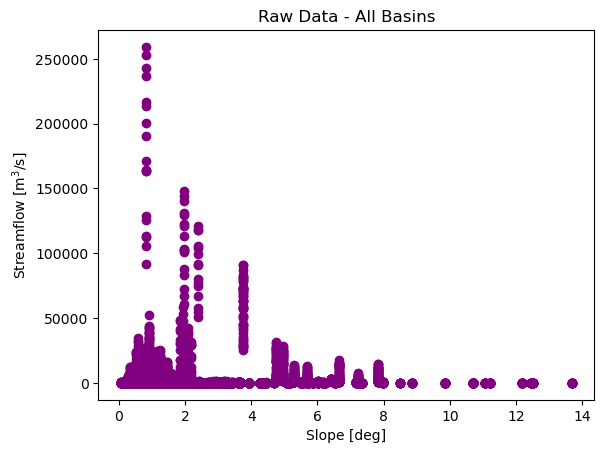

In [25]:
plt.scatter(avg_slope,q,color='purple')
plt.title('Raw Data - All Basins')
plt.xlabel('Slope [deg]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

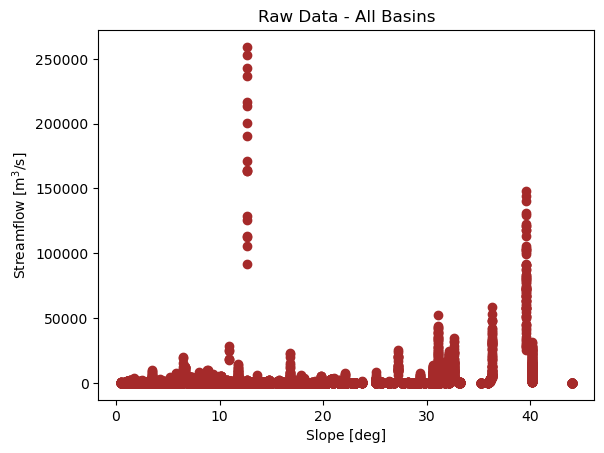

In [26]:
plt.scatter(max_slope,q,color='brown')
plt.title('Raw Data - All Basins')
plt.xlabel('Slope [deg]')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

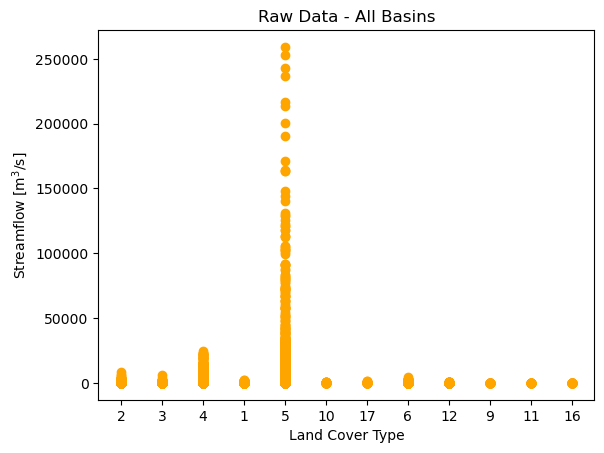

In [27]:
lc_class = lc_types.idxmax(axis=1)
plt.scatter(lc_class,q,color='orange')
plt.title('Raw Data - All Basins')
plt.xlabel('Land Cover Type')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

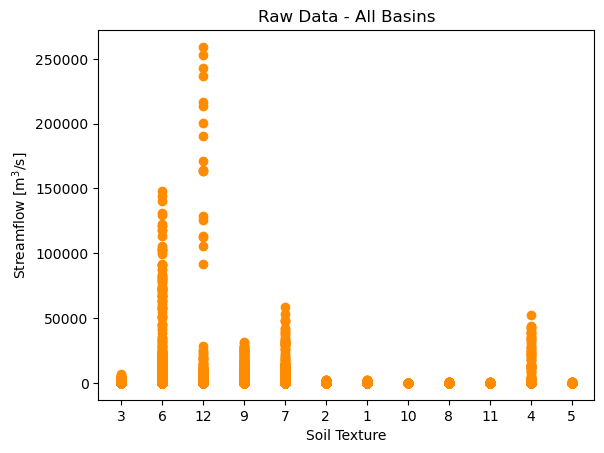

In [28]:
soil_class = soil_types.idxmax(axis=1)

plt.scatter(soil_class,q,color='darkorange')
plt.title('Raw Data - All Basins')
plt.xlabel('Soil Texture')
plt.ylabel('Streamflow [m${^3}$/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

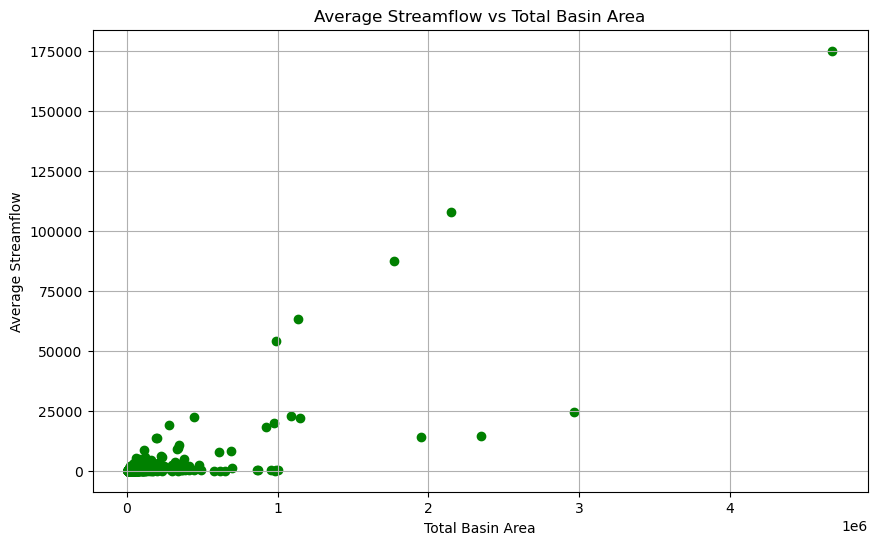

In [29]:
grouped = total_df.groupby('Area')['Q'].mean()

# Extract unique areas and their corresponding average Q values
area_unique = grouped.index
q_avg = grouped.values

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(area_unique, q_avg, color='g')
plt.xlabel('Total Basin Area')
plt.ylabel('Average Streamflow')
plt.title('Average Streamflow vs Total Basin Area')
plt.grid(True)
plt.show()

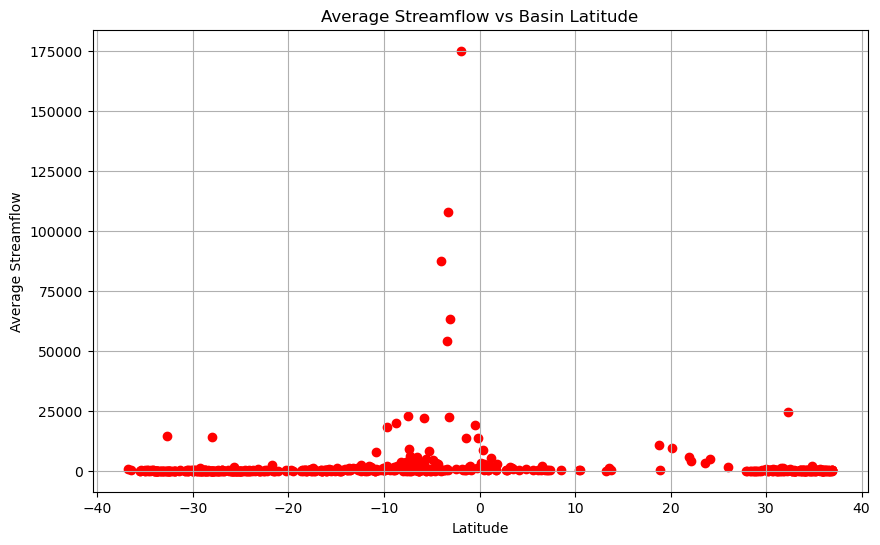

In [30]:
grouped = total_df.groupby('Latitude')['Q'].mean()

# Extract unique areas and their corresponding average Q values
lat_unique = grouped.index
q_avg = grouped.values

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(lat_unique, q_avg,color='red')
plt.xlabel('Latitude')
plt.ylabel('Average Streamflow')
plt.title('Average Streamflow vs Basin Latitude')
plt.grid(True)
plt.show()

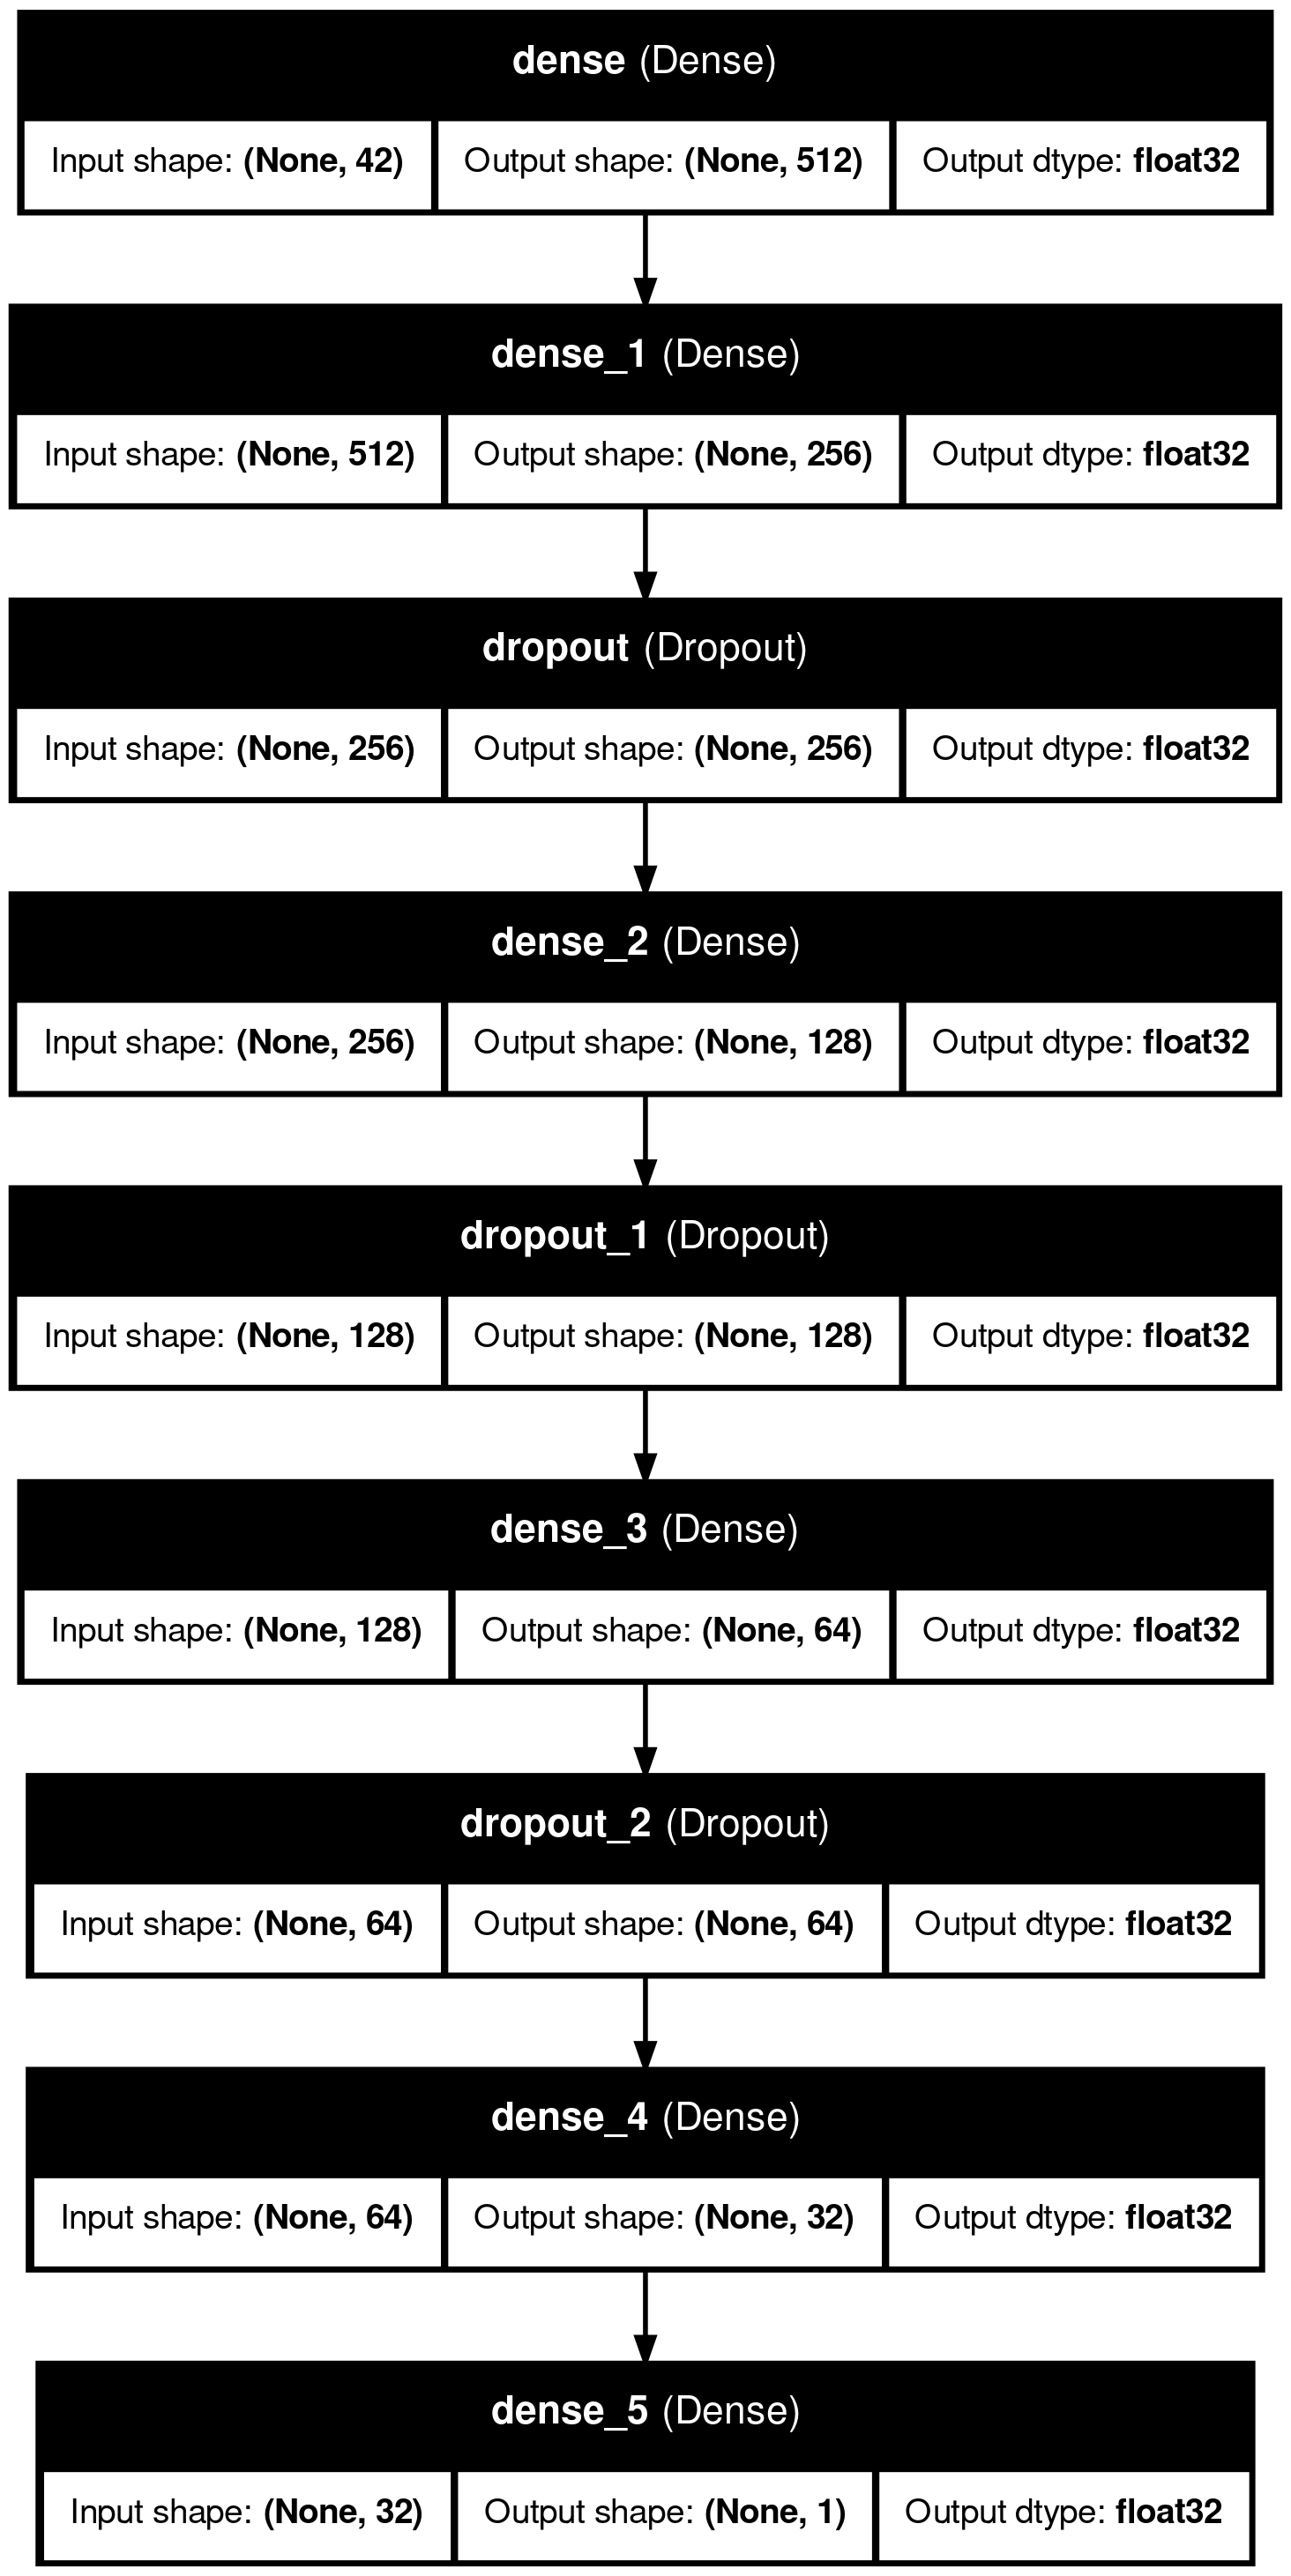

In [31]:
filename = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rnn_plot.png'
# Ensure the directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)
from tensorflow.keras.utils import plot_model

# Plot and save the model
plot_model(model,show_dtype=True, show_layer_names=True, show_shapes=True,  to_file=filename)

# # from IPython.display import Image
# # Image(filename)